# GalfitM process

In [1]:
import os
import shutil
import glob
import numpy as np
from astropy.io import fits
from astropy.table import Table
import subprocess
import matplotlib.pyplot as plt

In [2]:
img_name = 'nircam3'
prep_base = './io/prep/' + img_name + '/'
sample_base = './io/sample/' + img_name + '/'

## Prepare feedmes

In [11]:
from galfitclass import GalfitClass, SersicComponent

## Make Galfit Object with cutouts

In [8]:
sample_dir_list = glob.glob(f'./io/sample/{img_name}/EGS-*/')
sample_dir_list.sort()

customize calculate zeropoints

In [5]:
# custom
def calc_zpt(x: int, y: int)-> list:
    """
    Calculate zeropoint
    args:
        x: int
            x position

        y: int
            y position
    """
    CR = {'F115W':[0.914,0.908,0.862,0.813,0.959,0.897,0.995,0.831],
            'F150W':[1.005,0.966,0.932,0.855,1.000,0.968,0.988,0.865],
            'F200W':[0.865,0.889,0.800,0.791,0.873,0.829,0.901,0.812],
            'F277W':[1.107,1.107,1.107,1.107,1.000,1.000,1.000,1.000],
            'F356W':[1.088,1.088,1.088,1.088,1.000,1.000,1.000,1.000],
            'F410M':[1.031,1.031,1.031,1.031,1.042,1.042,1.042,1.042],
            'F444W':[1.036,1.036,1.036,1.036,1.096,1.096,1.096,1.096]
            }
    CR0 = {'F115W':[1,1,1,1,1,1,1,1],
            'F150W':[1,1,1,1,1,1,1,1],
            'F200W':[1,1,1,1,1,1,1,1],
            'F277W':[1,1,1,1,1,1,1,1],
            'F356W':[1,1,1,1,1,1,1,1],
            'F410M':[1,1,1,1,1,1,1,1],
            'F444W':[1,1,1,1,1,1,1,1]
            }
    
    let = x<5400 #letter B for left half, A for right half
    index = let << 2
    if let:
        index = index | ((x>2350) << 1) | (y>2300)
    else:
        index = index | ((x<8140) << 1) | (y<2400)
            
    #for updated version of PHOTMJSRs
    #print('zeropoints are adopted from jwst_0995.pmap\n')
    #return [28.086519392283982-2.5*np.log10(CR0[band][index]) for band in self.bands]

    #for ealier version of PHOTMJSRs
    print('Using magnitude zeropoints for F150W from Boyer et al. (2022), and for the other six filters, we use the zero points from Brammer (2022).\n')
    return [28.086519392283982-2.5*np.log10(CR[str(band)][index]) for band in CR.keys()]


In [3]:
pregalfit_path = prep_base + 'pregalfit.fits'
with fits.open(pregalfit_path) as hdul:
    tab_ini = Table(hdul['INIPARAM'].data)
tab_ini[tab_ini['EGS-ID']==28595]

EGS-ID,KronPhot_F115W_mag,KronPhot_F150W_mag,KronPhot_F200W_mag,KronPhot_F277W_mag,KronPhot_F356W_mag,KronPhot_F410M_mag,KronPhot_F444W_mag,label,xcentroid,ycentroid,orientation,eccentricity
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
28595,26.390905165469675,26.064402012364894,25.911454784138158,25.71896300052957,25.859116752627987,25.254578244717656,25.411488689756485,36859,1657.858598121969,4435.1063121706675,-54.89288594098392,0.8265685337513827


In [18]:
row_ini = tab_ini[tab_ini['EGS-ID']==28595]
row_ini['KronPhot_F356W_mag'][0]

25.859116752627987

### For single source

In [22]:
band_labels = ['F115W','F150W','F200W','F277W','F356W','F410M','F444W']
band_wavelengths = [115,150,200,277,356,410,444]
psf_list = [f'../GalfitPy3/io/psf/{band.lower()}_psf.fits' for band in band_labels]
seq = 21751
sample_dir = sample_base + f'EGS-{seq}/'
print('Processing: EGS-' + str(seq))

img_list = [sample_dir + 'sci_' + band + '.fits' for band in band_labels]
err_list = [sample_dir + 'err_' + band + '.fits' for band in band_labels]
bpmask_list = [sample_dir + 'bpmask_' + band + '.fits' for band in band_labels]

x_c = fits.getheader(img_list[0])['xc']
y_c = fits.getheader(img_list[0])['yc']
zpts = calc_zpt(x_c, y_c)

dict_band = dict(zip(band_labels, zip(band_wavelengths, zpts)))
# create a galfit object
gal_save_path = sample_dir + 'output.fits'
gal_obj = GalfitClass(dict_band, gal_save_path, plate_scale=(0.03,0.03))

gal_obj.load_data(img_list, err_list, bpmask_list)
gal_obj.load_psf(psf_list)
gal_obj.load_constraint('./constraint.txt')

# add a sersic component
sersic_comp = SersicComponent(gal_obj.nbands, skip=False)
sersic_comp.config_x(7, [gal_obj.image_size[0]/2+1]*7)
sersic_comp.config_y(7, [gal_obj.image_size[1]/2+1]*7)

row_ini = tab_ini[str(tab_ini['EGS-ID'])==seq]
mag_ini_list = [row_ini[f'KronPhot_{band}_mag'] for band in band_labels]
sersic_comp.config_mag(7, mag_ini_list)
sersic_comp.config_n(7, [2.0]*7)
sersic_comp.config_re(7, [5.0]*7)
sersic_comp.config_q(1, [row_ini['eccentricity']])
sersic_comp.config_pa(1, [row_ini['orientation']])
    
gal_obj.add_component(sersic_comp)

# generate feedme file
feedme = gal_obj.genstr_feedme()
feedme_path = sample_dir + f'{seq}.galfit'
with open(feedme_path, 'w') as f:
    f.write(feedme)

Processing: EGS-21751
Using magnitude zeropoints for F150W from Boyer et al. (2022), and for the other six filters, we use the zero points from Brammer (2022).

SCI images loaded
ERR images loaded
Bad pixel masks loaded
PSF images loaded
Constraint file loaded

GALFITM Version galfitm-1.4.4
(based on GALFIT Version 3.0.5)


#  Input menu file: ./io/sample/nircam2/EGS-21751/21751.galfit

# IMAGE and GALFIT CONTROL PARAMETERS
A) ./io/sample/nircam2/EGS-21751/sci_F115W.fits,./io/sample/nircam2/EGS-21751/sci_F150W.fits,./io/sample/nircam2/EGS-21751/sci_F200W.fits,./io/sample/nircam2/EGS-21751/sci_F277W.fits,./io/sample/nircam2/EGS-21751/sci_F356W.fits,./io/sample/nircam2/EGS-21751/sci_F410M.fits,./io/sample/nircam2/EGS-21751/sci_F444W.fits      # Input data image (FITS file)
A1) F115W,F150W,F200W,F277W,F356W,F410M,F444W     # Band labels
A2) 115.000,150.000,200.000,277.000,356.000,410.000,444.000     # Band wavelengths
B) ./io/sample/nircam2/EGS-21751/output.fits      # Output data image b

### Run GalfitM

In [ ]:
gal_obj.run(feedme_path)

## Check GalfitM Result

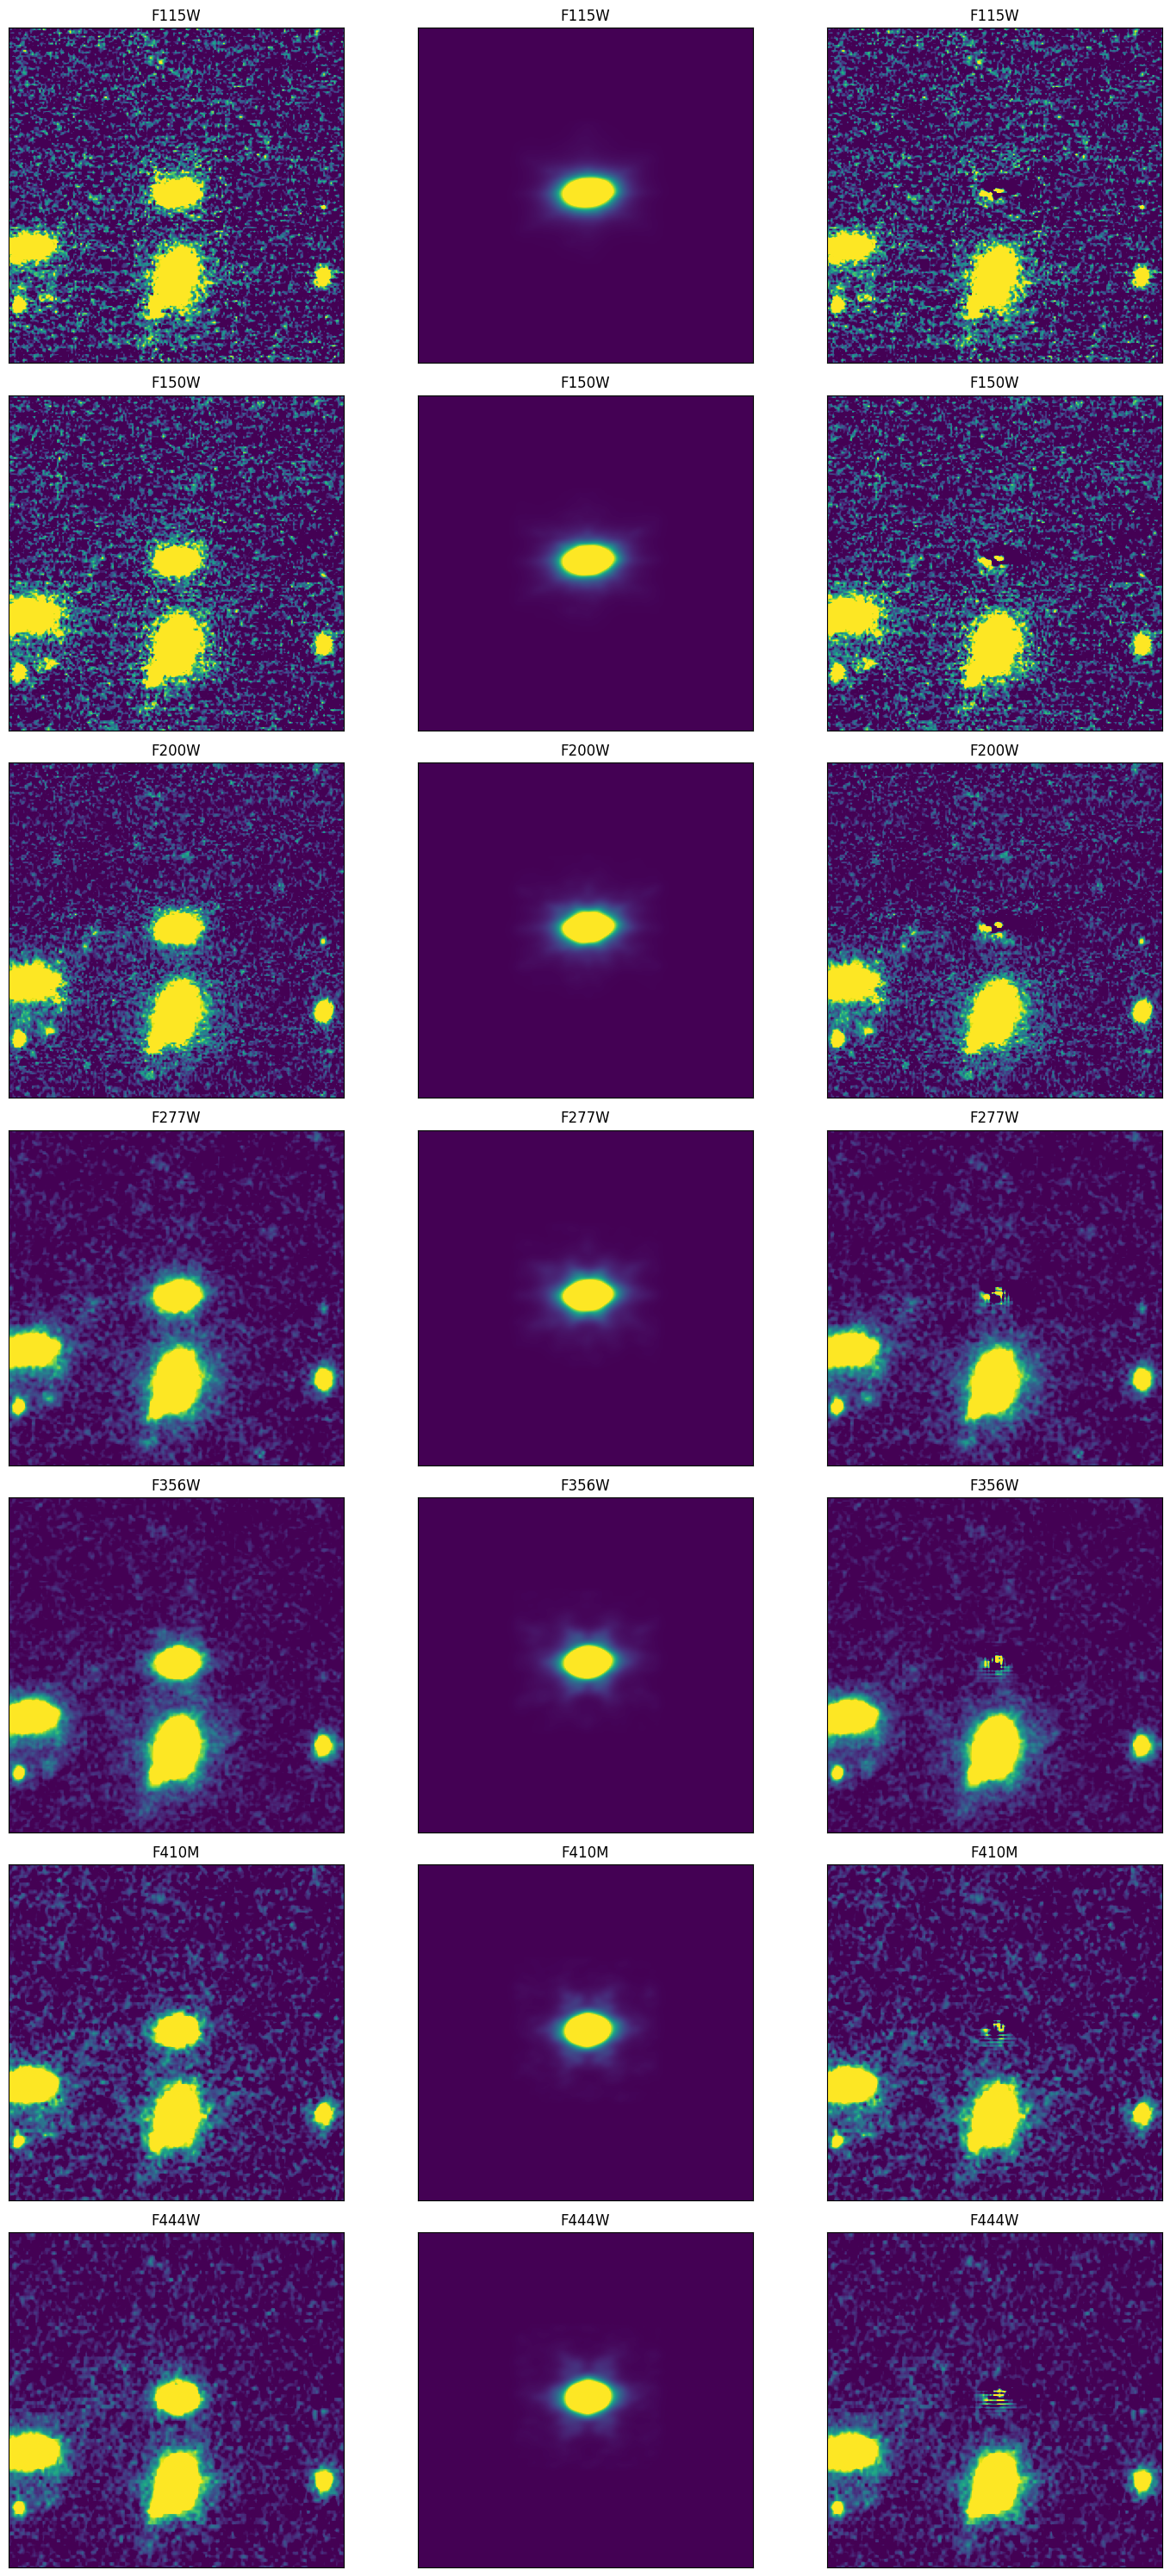

EGS-21751


In [23]:
fig, ax = plt.subplots(7,3,figsize=(15,30),sharex=True,sharey=True)
with fits.open(sample_dir + 'output.fits') as hdul:
    for i in range(7):
        for j in [1,0,2]:
            ax_data = hdul[1+j*7+i].data
            if j==1:
                vmin = np.percentile(ax_data,60)
                vmax = np.percentile(ax_data,99)
            ax[i,j].imshow(ax_data,origin='lower',vmin=vmin,vmax=vmax,cmap='viridis')
            ax[i,j].set_title(band_labels[i])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
plt.tight_layout()
plt.show()
print(sample_dir.split('/')[-2])

In [8]:
pa_ini_list = [1]
','.join([str(pa) for pa in pa_ini_list])

'1'